# This notebook talke the raw output from Hamiltonian Replica Exchange, extract the dihedral angle from xtc file using MdTraj, and ananlyze the autocoorelation curve

In [1]:
import os, sys, glob, shutil
import subprocess

import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import math
from IPython.display import Image, display
%matplotlib inline
nmer = 5
mpl.rcParams.update({'font.size': 16})

NameError: name 'N' is not defined

In [ ]:
%pwd

In [ ]:
import os
import subprocess

# Loop through each directory in the current working directory
for state_dir in os.listdir('.'):
    if os.path.isdir(state_dir) and state_dir.startswith('state_'):
        # Remove all files with # in their names
        rm_command = f'rm -f {os.path.join(state_dir, "#*")}'
        try:
            subprocess.run(rm_command, shell=True, check=True)
            print(f"Removed # files in {state_dir}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to remove # files in {state_dir}: {e}")

        input_gro = os.path.join(state_dir, 'HREMD.part0001.gro')
        output_gro = os.path.join(state_dir, 'HREMD_withoutwater.part0001.gro')
        command = f'echo "24\nq\n" | gmx editconf -f {input_gro} -n index.ndx -o {output_gro}'
        
        # Run the GROMACS command
        try:
            subprocess.run(command, shell=True, check=True)
            print(f"Processed {input_gro}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to process {input_gro}: {e}")


In [ ]:
# Define the directory path
directory = "omega_data/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")


In [ ]:
# Define omega dihedral indices, gromcas start from 1, while np start from 0
omega_dihedral_indices = np.array([
    [  4,   5,  18,  27],
    [ 27,  28,  41,  45],
    [ 45,  46,  57,  66],
])

# Ensure the omega_data directory exists
omega_path = 'omega_data/'
if not os.path.exists(omega_path):
    os.makedirs(omega_path)

# Calculate omegas for each state
for state in range(6):
    xtcfile = f"state_{state}/HREMD.part0001.xtc"
    grofile = f"state_{state}/HREMD_withoutwater.part0001.gro"
    traj = md.load(xtcfile, top=grofile)
    omegas = md.compute_dihedrals(traj, omega_dihedral_indices) * (180.0 / math.pi)

    # Save omegas
    outfile = os.path.join(omega_path, f"omegas_state{state}.npy")
    np.save(outfile, omegas)
    print(f"Saved omegas for state {state} to {outfile}")

In [ ]:
print(np.load('omega_data/omegas_state0.npy')[:5])

### What is the time interval between `*.xtc` snapshots?

In [2]:
%cat prod_fep.mdp | grep nstxout-compressed

nstxout-compressed      = 5000      ; save compressed coordinates every 10.0 ps


In [3]:
dt_in_ns = 0.010   #  ns

### What are the dimensions of the omega-angle arrays in each Hamiltonian state? 

In [4]:
nstates = 6

for i in range(nstates):
    omegas = np.load(f"omega_data/omegas_state{i}.npy")
    print(f'state {i}:, {omegas.shape}')

state 0:, (50001, 3)
state 1:, (50001, 3)
state 2:, (50001, 3)
state 3:, (50001, 3)
state 4:, (50001, 3)
state 5:, (50001, 3)


In [5]:
current_state = [0, 1, 2, 3, 4, 5]
logfile = 'state_0/HREMD.part0001.log'
pattern = 'Repl ex'
output_file = 'replica_indices.dat'

states = []
states.append( current_state.copy() ) # Make a copy of initial_state

# DEbug:  Let's see if xtc is written BEFORE swap 
states.append( current_state.copy() ) # Make a copy of initial_state

VERBOSE = False

try:

    with open(logfile, 'r') as file:
        lines = file.readlines()

        for line in lines:
            if pattern in line:
                parts = line.strip().split()
                if VERBOSE:
                    print(f'parts: {parts}')
                for i in range(2, len(parts)):
                    if 'x' in parts[i]:
                        index1 = int(parts[i-1])
                        index2 = int(parts[i+1])
                        
                        # Swap the positions in the current state
                        tmp1, tmp2 = current_state[index1], current_state[index2]
                        current_state[index1] = tmp2
                        current_state[index2] = tmp1
                states.append( current_state.copy() )  # Append a copy of the last state
    
    # DEbug:  Let's see if xtc is written BEFORE swap 
    if (0): 
        # for the last frame
        states.append( current_state.copy() )  # Append a copy of the state (last frame doesn't swap)

                
    # Write states to output_file
    with open(output_file, 'w') as outfile:
        for state in states:
            outfile.write(' '.join(map(str, state)) + '\n')

    print(f"Output saved to {output_file}")


except FileNotFoundError:
    print(f"The file {logfile} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

Output saved to replica_indices.dat


In [6]:
all_omegas = [] # Load in the omega values for all replicas
for state in range(6):  # Adjust the range to include all replicas
    all_omegas.append(np.load(f"omega_data/omegas_state{state}.npy"))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)
#print(all_omegas[:5])

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('replica_indices.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)

all_omegas_by_replica = np.zeros(all_omegas.shape)

start = 0
nsnaps = 50001
nreps = 6
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :])
    all_omegas_by_replica[:, i, :] = all_omegas[Ind, i, :]

# Save the data for each state once
for rep in range(nreps):
    np.save(f"omega_data/omegas_rep{rep}.npy", all_omegas_by_replica[rep, :, :])
    print(f"Saved omegas for replica {rep} to omega_data/omegas_rep{rep}.npy")
    #print(np.load(f'omega_data/omegas_rep{rep}.npy')[:5])

all_omegas.shape (6, 50001, 3)
replica_indices.shape (50001, 6)
Saved omegas for replica 0 to omega_data/omegas_rep0.npy
Saved omegas for replica 1 to omega_data/omegas_rep1.npy
Saved omegas for replica 2 to omega_data/omegas_rep2.npy
Saved omegas for replica 3 to omega_data/omegas_rep3.npy
Saved omegas for replica 4 to omega_data/omegas_rep4.npy
Saved omegas for replica 5 to omega_data/omegas_rep5.npy


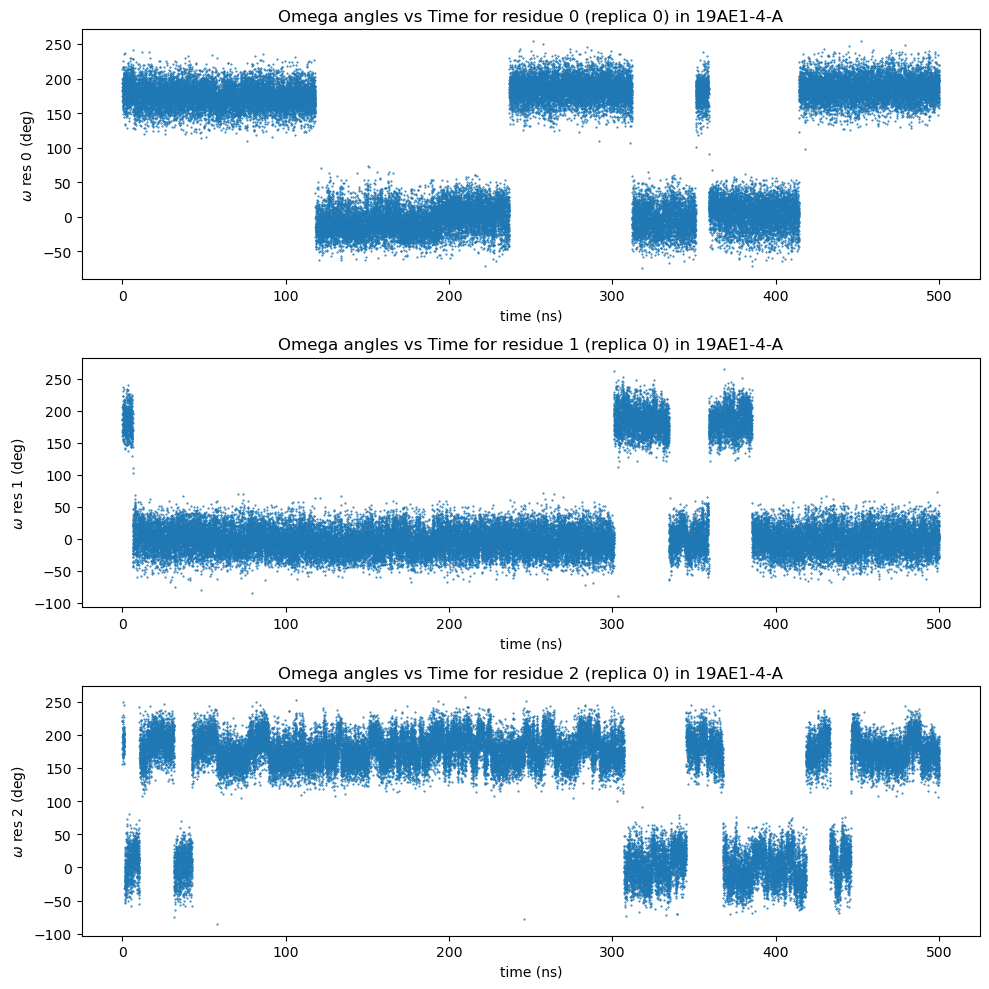

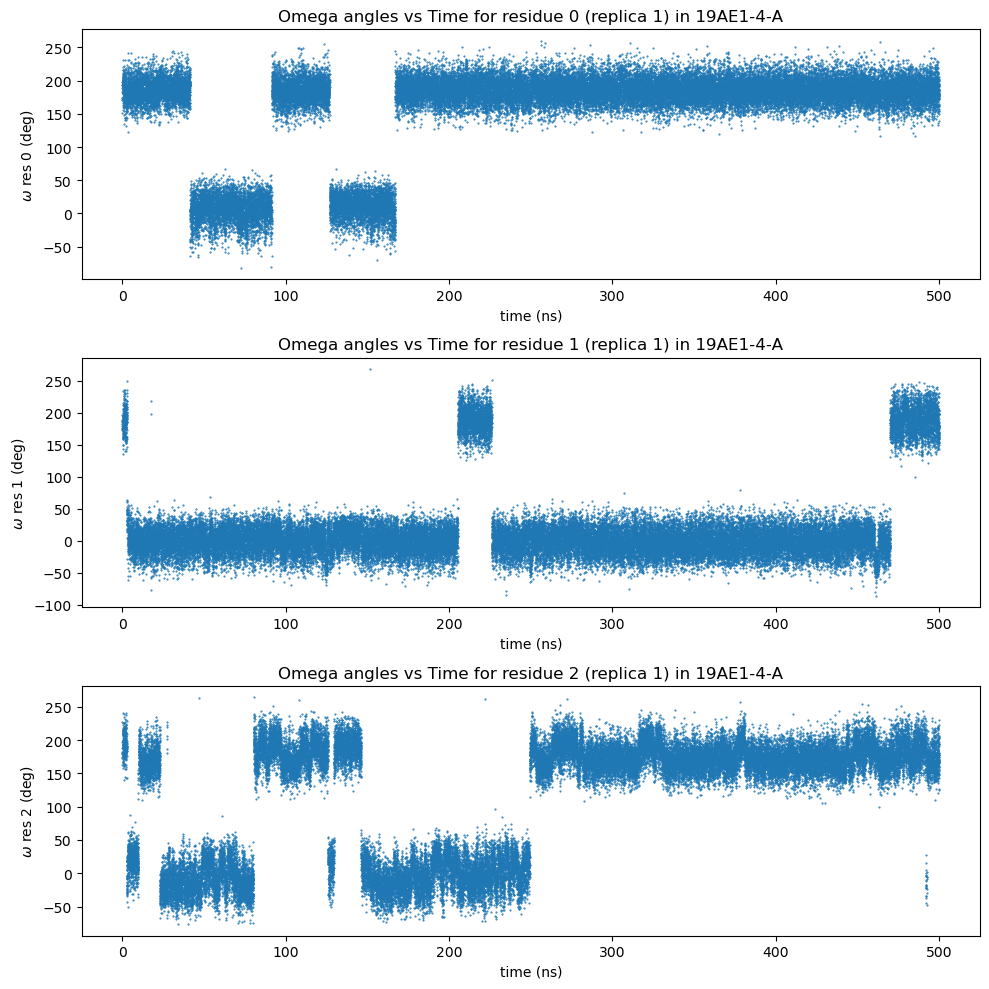

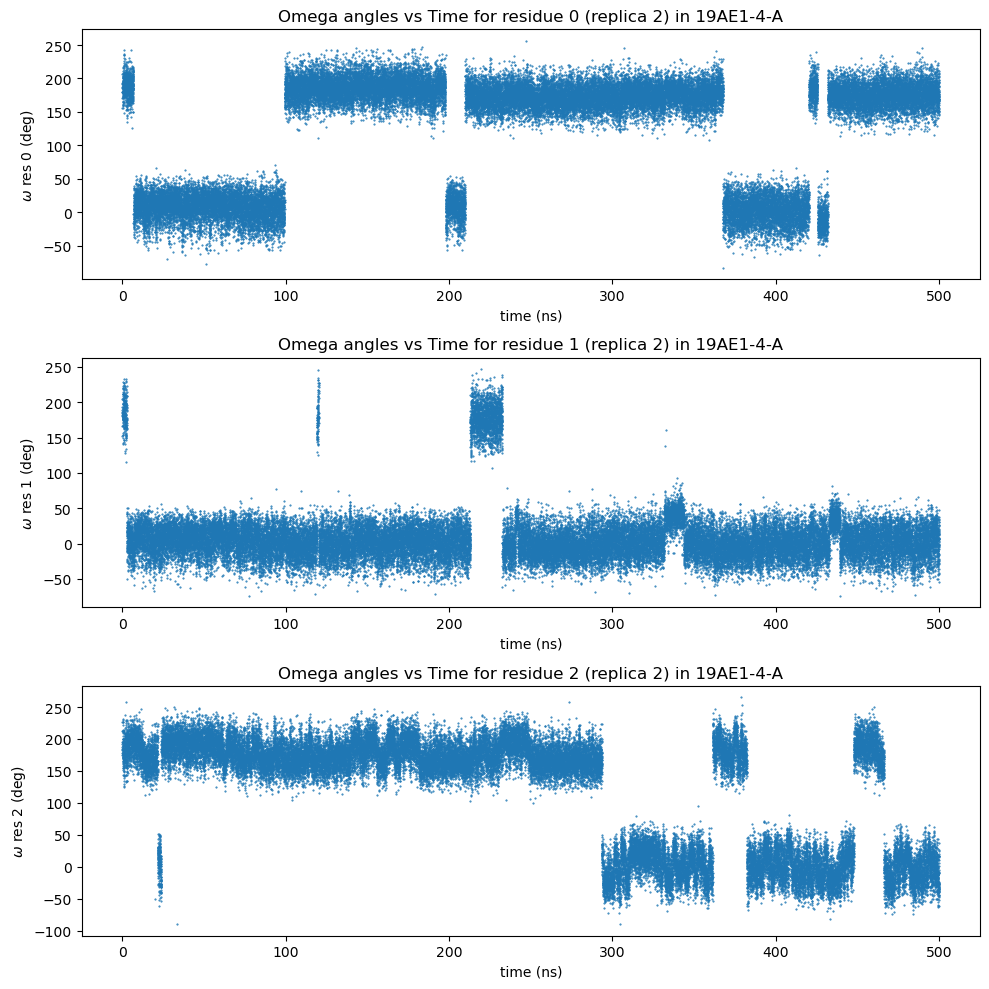

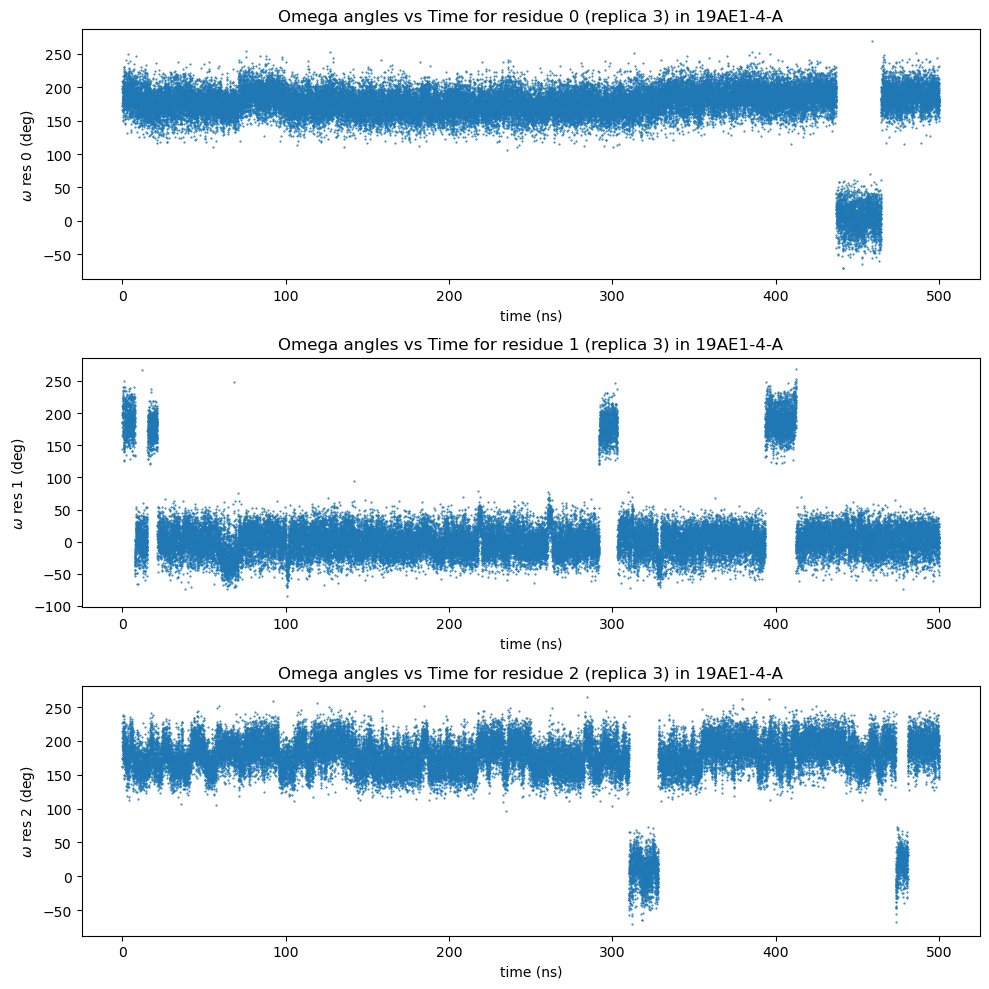

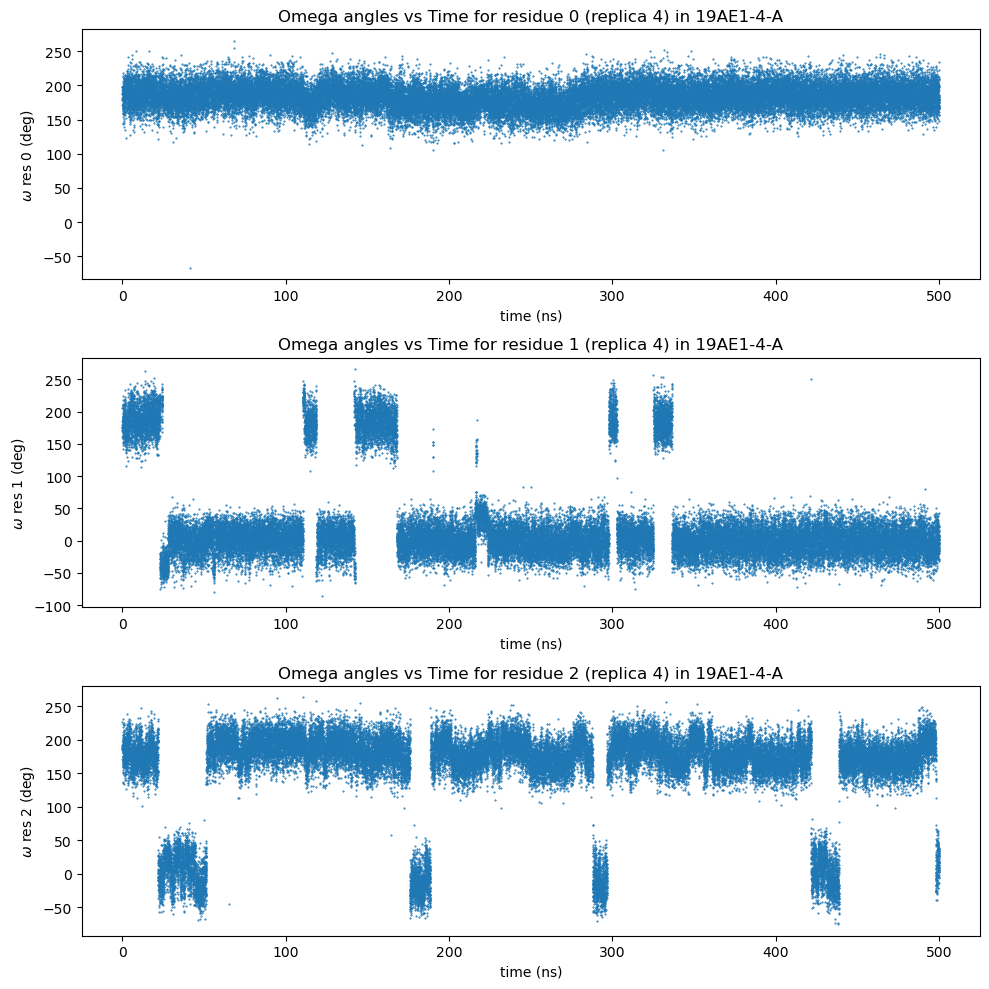

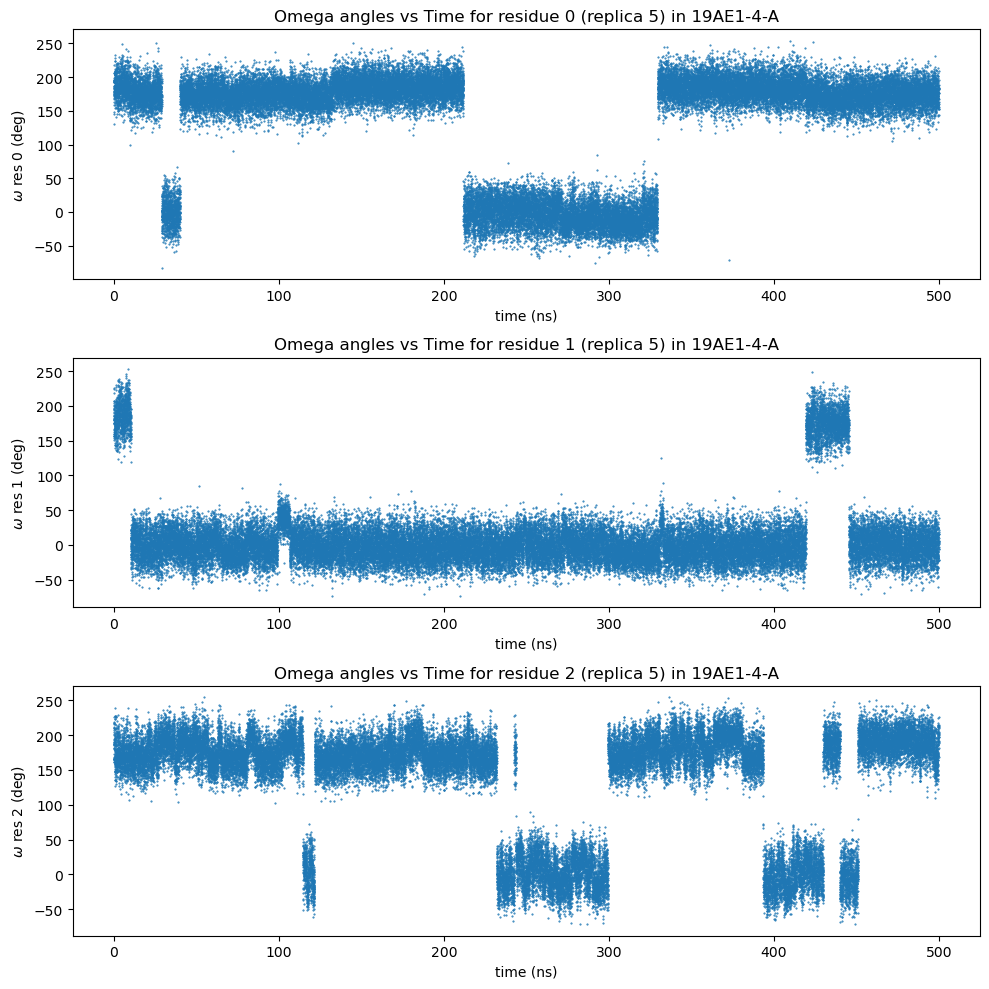

In [7]:
# Adjust omega values into the range (-90, 270)
all_omegas_by_replica = (all_omegas_by_replica + 90.0) % 360.0 - 90.0

start = 0
nsnaps = 50001
nreps = 6
residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)

ShowPlots = True

# Plot omega angles vs time for selected residues for each replica
for i in range(nreps):
    plt.figure(figsize=(10, 10))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(num_residues, 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, all_omegas_by_replica[i, start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AE1-4-A')
    plt.tight_layout()
    if ShowPlots:
        plt.show()
    else:
        outfilename = f'omega_data/Omega_angles_vs_Time_residue_{residue}_Replica_{i}_in_19AE1-4-A.png'
        plt.savefig(outfilename)
        print(f"Saved at: {outfilename}")
        plt.clf()  # Clear the figure for the next set of plots

## Autocoorelation 

In [8]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    g = np.correlate(x, x, mode='full')[tau-1:]
    n = np.arange(tau,0,-1)
    return g/n

avg_autocorrel = [] 
for residue in range(3):
    all_autocorrel = []
    for replica in range(6):
        # Example calculation, replace with your actual calculation
        cis_trans = np.where(all_omegas[replica,:,residue] > 90.0, 1.0, 0.0)
        print(f"residue {residue}, replica {replica}, cis_trans: {cis_trans}")
        
        all_autocorrel.append(autocorr(cis_trans))
    
    avg_autocorrel.append(np.array(all_autocorrel).mean(axis=0))
    outfile = f'omega_data/omega_autocorrel_residue{residue}.npy'
    print(f"Saving {outfile} ...")
    np.save(outfile, avg_autocorrel[-1]) 


residue 0, replica 0, cis_trans: [0. 0. 0. ... 1. 0. 0.]
residue 0, replica 1, cis_trans: [0. 1. 0. ... 1. 0. 0.]
residue 0, replica 2, cis_trans: [0. 0. 1. ... 0. 0. 0.]
residue 0, replica 3, cis_trans: [0. 1. 1. ... 0. 1. 0.]
residue 0, replica 4, cis_trans: [0. 0. 0. ... 1. 0. 0.]
residue 0, replica 5, cis_trans: [0. 1. 0. ... 0. 0. 0.]
Saving omega_data/omega_autocorrel_residue0.npy ...
residue 1, replica 0, cis_trans: [0. 0. 1. ... 0. 0. 0.]
residue 1, replica 1, cis_trans: [0. 1. 1. ... 0. 0. 0.]
residue 1, replica 2, cis_trans: [0. 0. 0. ... 0. 0. 1.]
residue 1, replica 3, cis_trans: [0. 1. 0. ... 0. 0. 0.]
residue 1, replica 4, cis_trans: [0. 1. 1. ... 1. 0. 0.]
residue 1, replica 5, cis_trans: [0. 0. 1. ... 0. 0. 0.]
Saving omega_data/omega_autocorrel_residue1.npy ...
residue 2, replica 0, cis_trans: [0. 0. 0. ... 0. 1. 0.]
residue 2, replica 1, cis_trans: [0. 0. 1. ... 0. 1. 1.]
residue 2, replica 2, cis_trans: [0. 0. 0. ... 1. 0. 0.]
residue 2, replica 3, cis_trans: [0. 0. 0

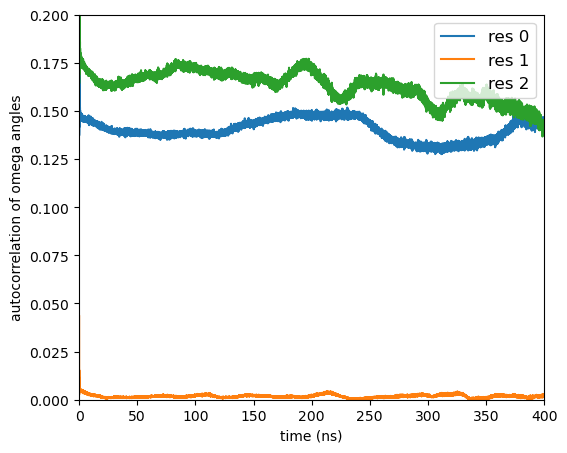

In [9]:
avg_autocorrels = []
plt.figure(figsize=(6,5))
t = np.arange(0, len(cis_trans))*0.010 # frames saved every 10 ps

for residue in range(0,3):   # the last residue
    infile = f'omega_data/omega_autocorrel_residue{residue}.npy'
    data = np.load(infile)
    avg_autocorrels.append(data)
    plt.plot(t, data, label='res %d'%residue)
    plt.xlim(0,400) # only show first part of the autocorrelation curves
    plt.ylim(0,0.2) # only show first part of the autocorrelation curves

plt.xlabel('time (ns)')
plt.ylabel('autocorrelation of omega angles')
plt.legend(loc='upper right', fontsize=12)

plt.show()

--- Residue 0 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.14000230843295786 +/- 8.647987302799376e-10
Best-fit a1: 0.009442791420707997 +/- 1.2016487295714146e-07
Best-fit tau: 10.30509059464111 +/- 0.3032008648360555
--- Residue 1 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.0017336625804986823 +/- 1.2753546491506118e-11
Best-fit a1: 0.004384974835011528 +/- 3.5413967485215623e-09
Best-fit tau: 5.428036394281308 +/- 0.01119229431407429
--- Residue 2 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: -1048.937428967119 +/- 5129122.168006489
Best-fit a1: 1049.1107671472776 +/- 5129122.15153546
Best-fit tau: 20470760.3899736 +/- 1952888258068072.5


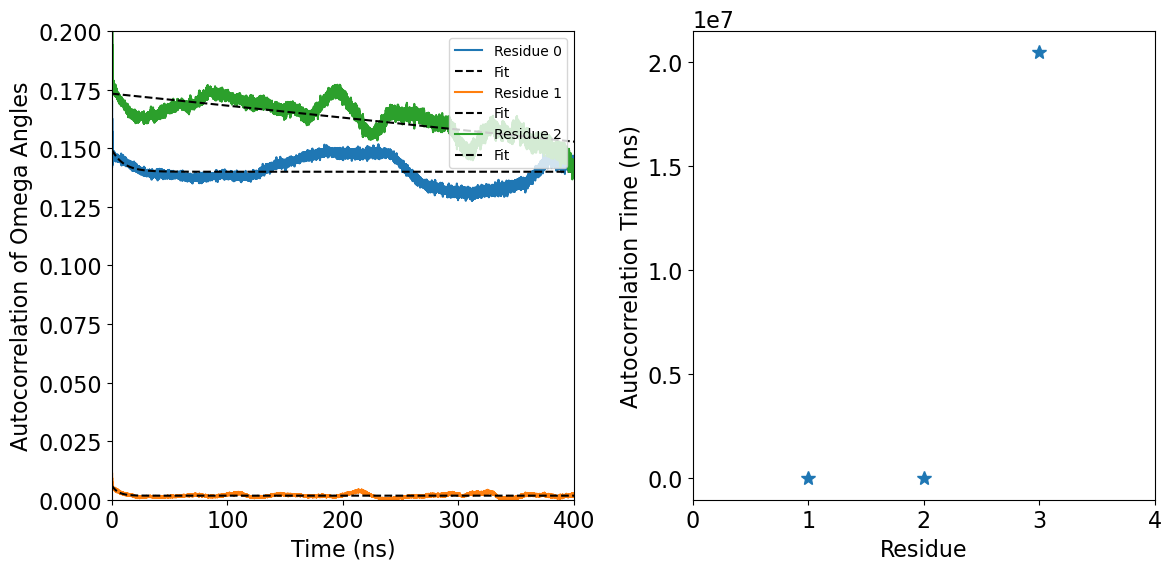

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Functional form for fitting
def single_exp_decay(x, a0, a1, tau):
    return a0 + a1 * np.exp(-x / tau)

# Fit each autocorrelation and plot results
fit_taus = []

plt.figure(figsize=(12, 6))

# Loop over each residue
for residue in range(3):
    
    # Initial guess for fitting parameters
    first_value = avg_autocorrels[residue][0]
    initial_guess = [first_value / 2.0, first_value / 2.0, 40.0]  # Initial guess [a0, a1, tau]
    
    # Perform curve fitting
    popt, pcov = curve_fit(single_exp_decay, t[:40000], avg_autocorrels[residue][:40000], p0=initial_guess)
    
    # Compute fitted curve
    y_fit = single_exp_decay(t[:40000], *popt)
    
    # Collect fitted tau values
    fit_taus.append(popt[2])
    
    # Print fit results
    print(f'--- Residue {residue} ---')
    print('### FIT to a0 + a1*exp(-(x/tau)) ###')
    print(f'Best-fit a0: {popt[0]} +/- {pcov[0][0]}')
    print(f'Best-fit a1: {popt[1]} +/- {pcov[1][1]}')
    print(f'Best-fit tau: {popt[2]} +/- {pcov[2][2]}')

    # Plot original data and fitted curve
    plt.subplot(1, 2, 1)
    plt.plot(t[:40000], avg_autocorrels[residue][:40000], label=f'Residue {residue}')
    plt.plot(t[:40000], y_fit, 'k--', label='Fit')
    plt.xlim(0, 400)
    plt.ylim(0, 0.2)
    plt.xlabel('Time (ns)')
    plt.ylabel('Autocorrelation of Omega Angles')
    plt.legend(loc='upper right', fontsize=10)
    
# Plotting the fitted tau values
plt.subplot(1, 2, 2)
plt.plot(range(1, 4), fit_taus, '*', markersize=10)
plt.xlim(0, 4)
plt.xlabel('Residue')
plt.ylabel('Autocorrelation Time (ns)')
plt.tight_layout()

plt.show()
